## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [1]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

import random
import os

from gensim.models import KeyedVectors

### 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [2]:
# We set min_count=1 to include all words in the corpus
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)

Total vocabulary: 1352


In [3]:
def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### YOUR CODE HERE ###

    word_ids = [] # convert the list of words to a list of word ids
    for word in words:
        word_ids.append(corpus.word2id[word])
    # Use for loop and yield
    for i, word in enumerate(word_ids):
        # avoid index out of range near the beginning and end, [ i-window_size, i+window_size ]
        for j in range(max(0, i - window_size), min(len(word_ids), i + window_size + 1)):
            if i != j:
                # center, outside, negatives
                yield word, word_ids[j], corpus.getNegatives(word, k)
                
    ### END YOUR CODE ###

def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]
        
        ### YOUR CODE HERE ###
        center = torch.LongTensor(np.array([item[0] for item in batch]))
        outside = torch.LongTensor(np.array([item[1] for item in batch]))
        negative = torch.LongTensor(np.array([item[2] for item in batch]))
        yield center, outside, negative
        ### END YOUR CODE ###


### Read the data and get batches

In [7]:
with open("lunyu_20chapters.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

In [8]:
data = []
for line in lines[:5]:
    words = list(line.strip())
    data.extend(list(generate_data(words, window_size=2, k=3, corpus=corpus)))

In [9]:
batches = list(batchify(data, batch_size=4))
batches[0], len(batches)

((tensor([1, 1, 4, 4]),
  tensor([4, 3, 1, 3]),
  tensor([[ 323,   83,    7],
          [  77,  384,  661],
          [   2,  147,  275],
          [ 905, 1070,   20]])),
 160)

### 2. Build the Model

In [7]:
import torch.nn.functional as F

class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True) # center
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True) # context(neighbor)

        initrange = 1.0 / self.emb_size # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange) # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0) # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args: (B: batch size, k: number of negative samples)
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center) # (B, emb_size)
        u_o = self.emb_u(outside) # (B, emb_size)
        u_n = self.emb_u(negative) # (B, k, emb_size)

        ### YOUR CODE HERE ###
        pos_score = torch.sum(torch.mul(v_c, u_o), dim=1)
        pos_score = torch.clamp(pos_score, max=10, min=-10)
        pos_score = F.logsigmoid(pos_score)

        neg_score = torch.bmm(u_n, -v_c.unsqueeze(2)).squeeze(2)
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = torch.sum(F.logsigmoid(neg_score), dim=1)

        return -pos_score - neg_score
        ### END YOUR CODE ###
    
    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

### 3. Train and Evaluate

In [8]:
# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
emb_size = 50
window_size = 1
k = 5 # the number of negative samples, change with your own choice for better embedding performance
min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function

epoch = 15
gamma = 0.88 # for step scheculer
# because our data is small. If min_count > 1, 
# you should filter out those unknown words from the data in train() function

import math
initial_lr * math.pow(gamma,epoch)

0.0036743463475028154

In [9]:
def train(model: SkipGram, batches: List, corpus: CorpusReader, device: torch.device, scheduler,
          optimizer, epoch: int, out_file: str = 'out_vec.txt', log_file: str = 'dummy'):

    # Write your own code for this train function
    with open(log_file, 'w') as f:
        f.write('embedding_size: ' + str(model.emb_size) + '\n')
        f.write('k: ' + str(k) + '\n')
        f.write('window_size: ' + str(window_size) + '\n')

    model.train()
    log_interval = 500
    for iteration in range(epoch):
        print("\n\n\nIteration: " + str(iteration))

        random.shuffle(batches)
        epoch_loss = 0.0
        for i, (centor, outside, negative) in enumerate(batches):
            v_c = centor.to(device)
            u_o = outside.to(device)
            u_n = negative.to(device)

            optimizer.zero_grad()
            loss = model.forward(v_c, u_o, u_n).mean()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            if i % log_interval == 0 and i > 0:
                print(
                    "| epoch {:3d} | {:5d}/{:5d} batches "
                    "| loss {:8.3f}".format(
                        iteration, i, len(batches), loss.item()
                    )
                )
             
        scheduler.step()
        print(f'current lr: {scheduler.get_last_lr()}')
        print(f"iteration {iteration} Loss: " + str(epoch_loss/len(batches)))

        with open(log_file, 'a') as f:
            f.write('iteration ' + str(iteration) + ', epoch loss: ' + str(epoch_loss/len(batches)) + '\n')

    model.save_embedding(corpus.id2word, out_file)

### Test train


In [10]:

print(f"emb_size: {emb_size}, k: {k}, window_size: {window_size}")
# get batches
data = []
for line in lines:
    words = list(line.strip())
    data.extend(list(generate_data(words, window_size=window_size, k=k, corpus=corpus)))
batches = list(batchify(data, batch_size=batch_size))
print(f"len(data): {len(batches)}")

model = SkipGram(corpus.vocab_size, emb_size)
device = torch.device("cpu")

model.to(device)

optimizer = torch.optim.SparseAdam(model.parameters(), lr=initial_lr) # or torch.optim.SparseAdam()
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)


emb_size: 50, k: 5, window_size: 1
len(data): 2485


/home/cooper/.conda/envs/llm/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [11]:
train(model, batches, corpus, device, scheduler, optimizer, epoch=epoch,
        out_file=f'emb/embedding_emb{emb_size}_neg{k}_win{window_size}.txt',
        log_file=f'log/log_emb{emb_size}_neg{k}_win{window_size}.txt')




Iteration: 0
| epoch   0 |   500/ 2485 batches | loss    2.260
| epoch   0 |  1000/ 2485 batches | loss    2.341
| epoch   0 |  1500/ 2485 batches | loss    2.844
| epoch   0 |  2000/ 2485 batches | loss    3.162
current lr: [0.022000000000000002]
iteration 0 Loss: 2.909939905191571



Iteration: 1
| epoch   1 |   500/ 2485 batches | loss    1.365
| epoch   1 |  1000/ 2485 batches | loss    1.973
| epoch   1 |  1500/ 2485 batches | loss    1.539
| epoch   1 |  2000/ 2485 batches | loss    2.501
current lr: [0.019360000000000002]
iteration 1 Loss: 2.321121300346175



Iteration: 2
| epoch   2 |   500/ 2485 batches | loss    1.979
| epoch   2 |  1000/ 2485 batches | loss    2.306
| epoch   2 |  1500/ 2485 batches | loss    1.416
| epoch   2 |  2000/ 2485 batches | loss    1.851
current lr: [0.0170368]
iteration 2 Loss: 1.9671732937546083



Iteration: 3
| epoch   3 |   500/ 2485 batches | loss    1.256
| epoch   3 |  1000/ 2485 batches | loss    1.318
| epoch   3 |  1500/ 2485 batches

### Train with different hyperparameters

In [12]:
paras = []
for emb_size in [50, 100]:
    for k in [5, 10, 15]:
        for window_size in [1, 3, 5]:
            paras.append((emb_size, k, window_size))
len(paras)

18

In [224]:
# logging and embedding path
log_path = os.getcwd() + "/log"
emb_path = os.getcwd() + "/emb"
if not os.path.exists(log_path):
    os.makedirs(log_path)
if not os.path.exists(emb_path):
    os.makedirs(emb_path)

In [ ]:
for emb_size, k, window_size in paras:
    print(f"emb_size: {emb_size}, k: {k}, window_size: {window_size}")

    data = []
    for line in lines:
        words = list(line.strip())
        data.extend(list(generate_data(words, window_size=window_size, k=k, corpus=corpus)))
    batches = list(batchify(data, batch_size=batch_size))
    print(f"len(data): {len(batches)}")

    model = SkipGram(corpus.vocab_size, emb_size)
    device = torch.device("cpu")
    # device = torch.device("mps" if torch.backends.mps.is_built() else "cpu") # for apple silicon Mac
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for GPU
    model.to(device)

    optimizer = torch.optim.SparseAdam(model.parameters(), lr=initial_lr) # or torch.optim.SparseAdam()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)

    train(model, batches, corpus, device, scheduler, optimizer, epoch=epoch,
          out_file=f'emb/embedding_emb{emb_size}_neg{k}_win{window_size}.txt',
          log_file=f'log/log_emb{emb_size}_neg{k}_win{window_size}.txt')

### 4. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [13]:
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
words = ['学', '习', '曰', '子', '人', '仁', '吾', '我', '言','君','父','母', '善', '恶']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2','wu','wo','yan','jun', 'fu', 'mu', 'shan', 'e']

### YOUR CODE HERE ###
word_indices = [corpus.word2id[word] for word in words]


### Test load and plot

In [3]:
word_vectors = KeyedVectors.load_word2vec_format('emb/embedding_emb50_neg5_win3.txt', binary=False)
word_vectors.vectors

array([[-0.8893851 , -0.01169008, -0.06599595, ..., -0.04615472,
        -0.06077141, -0.08226693],
       [-0.07986124, -0.04431435,  0.09862717, ...,  0.01679957,
        -0.02586622, -0.07444499],
       [-0.411154  ,  0.00472985, -0.02767293, ...,  0.11269164,
         0.18928903, -0.02365988],
       ...,
       [-0.68013734,  0.26370293, -0.04426989, ...,  0.5171932 ,
        -0.06979804, -0.7704182 ],
       [-0.2420654 ,  0.41611975, -0.63119066, ...,  0.03697841,
         0.2411417 ,  0.07123455],
       [-0.5752773 ,  0.71262336,  0.08152021, ..., -0.39544103,
         0.50630045, -0.49576768]], dtype=float32)

In [15]:
embedding = word_vectors.vectors

In [16]:
# Truncated SVD
### YOUR CODE HERE ###
svd = TruncatedSVD(n_components=2)
embedding_2d = svd.fit_transform(embedding)
### END YOUR CODE ###

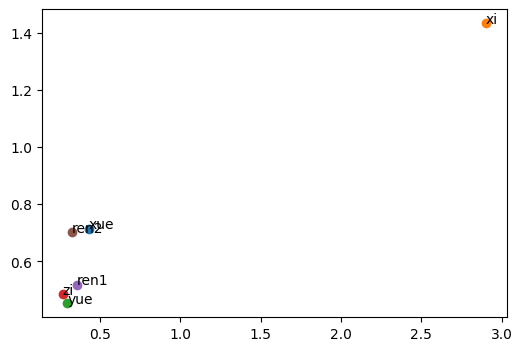

In [24]:
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']

### YOUR CODE HERE ###
word_indices = [corpus.word2id[word] for word in words]

selected_embeddings = embedding_2d[word_indices]

plt.figure(figsize=(6, 4))
for word, emb_point in zip(words_pinyin, selected_embeddings):
    plt.scatter(emb_point[0], emb_point[1], label=word)
    plt.text(emb_point[0], emb_point[1], word)

### END YOUR CODE ###

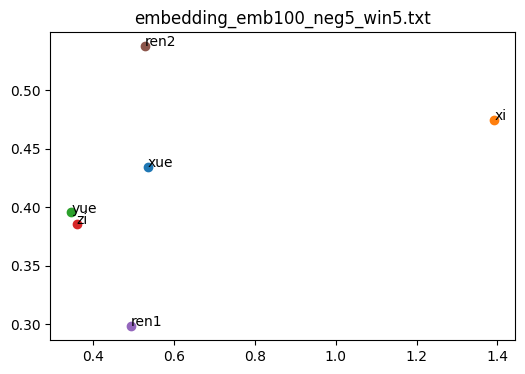

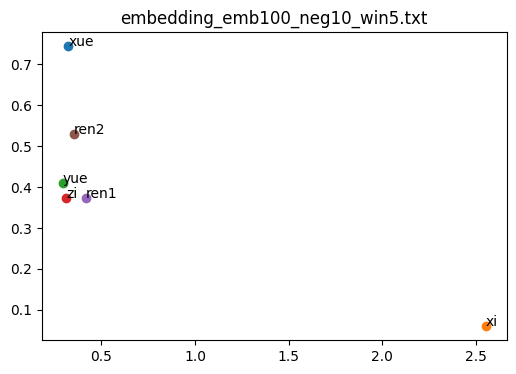

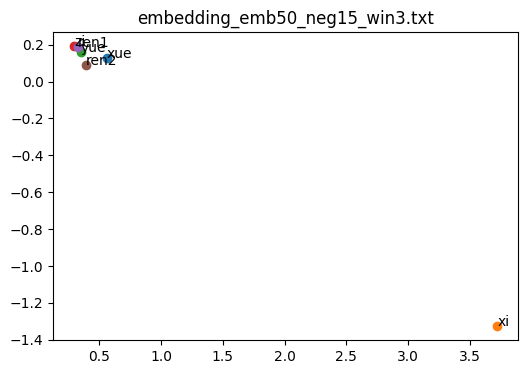

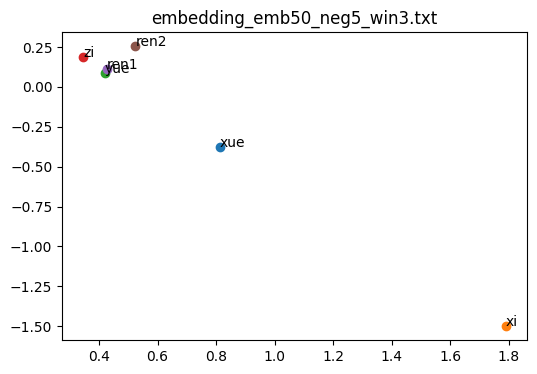

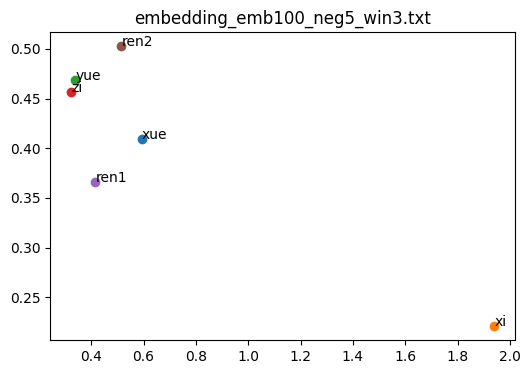

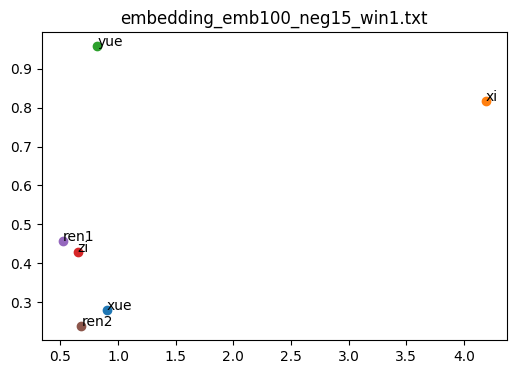

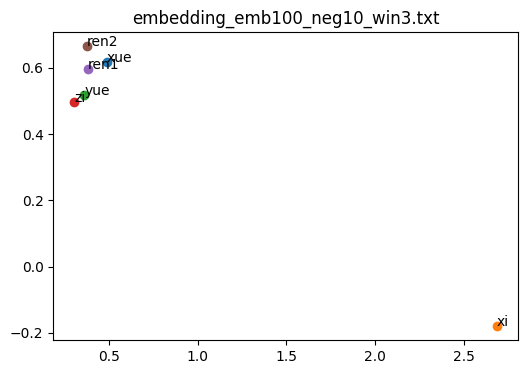

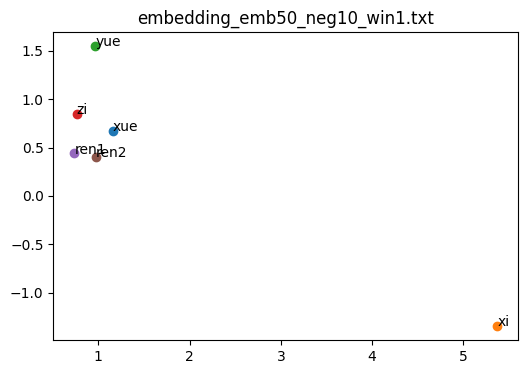

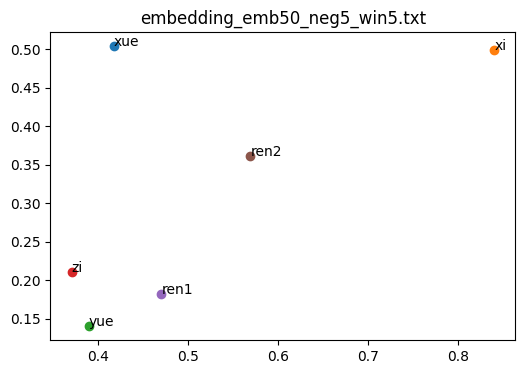

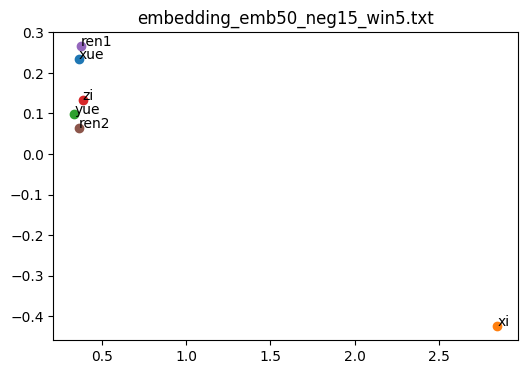

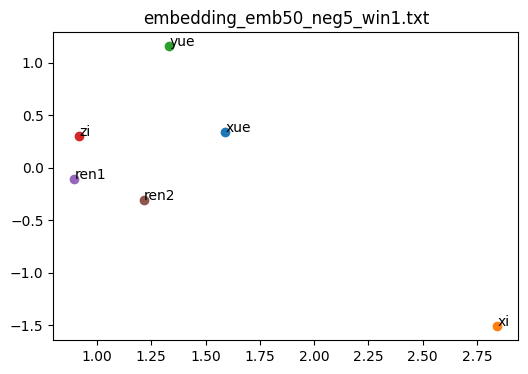

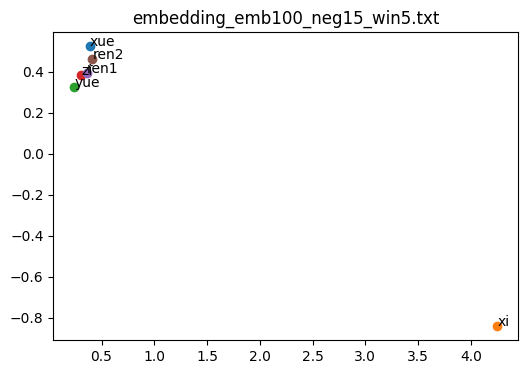

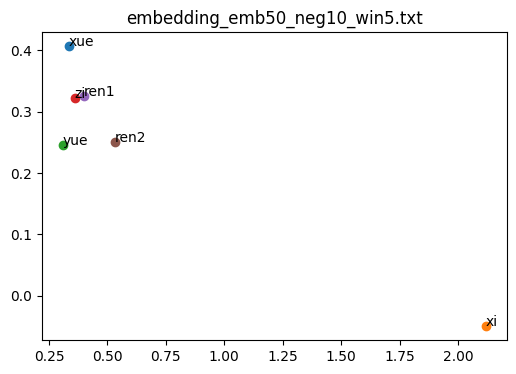

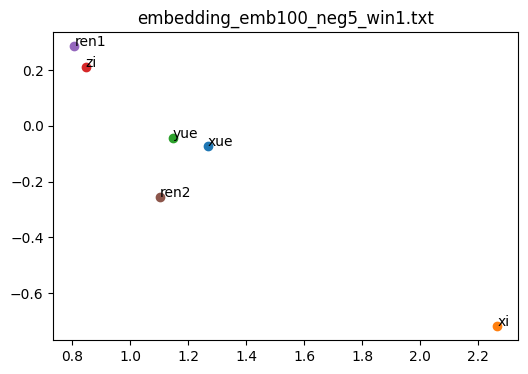

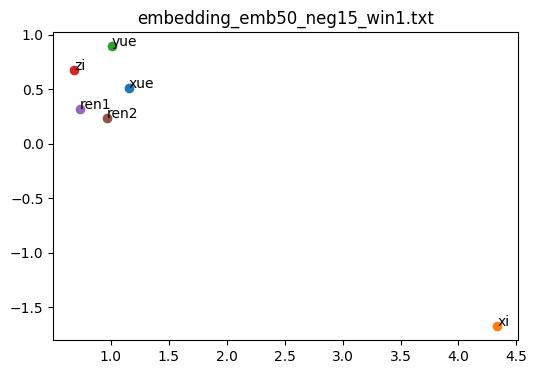

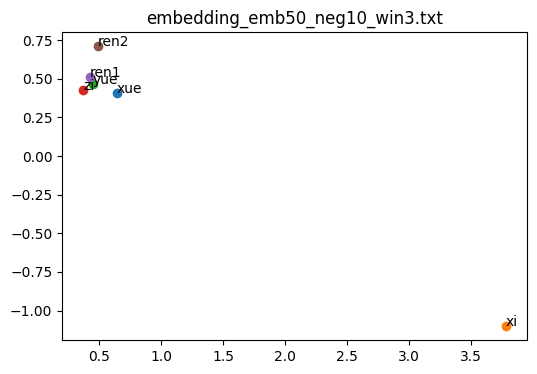

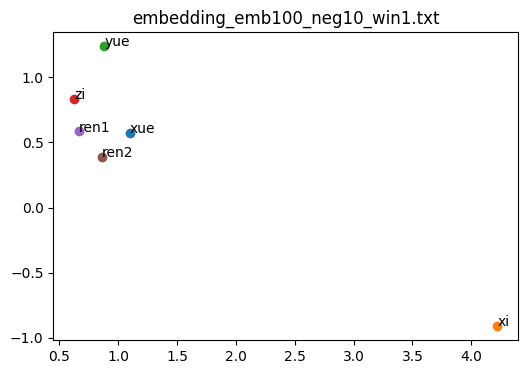

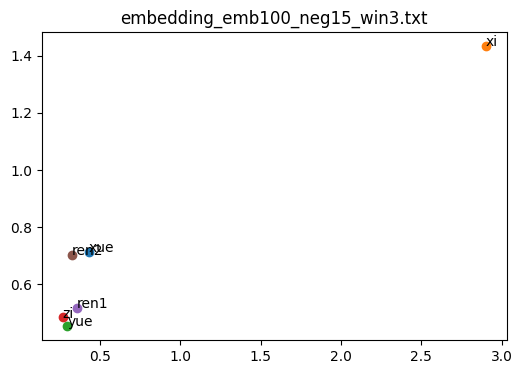

In [26]:
files = os.listdir('emb')

for file in files:
    word_vectors = KeyedVectors.load_word2vec_format(f'emb/{file}', binary=False)
    embedding = word_vectors.vectors
    # Truncated SVD
    svd = TruncatedSVD(n_components=2)
    embedding_2d = svd.fit_transform(embedding)

    selected_embeddings = embedding_2d[word_indices]

    plt.figure(figsize=(6, 4))
    plt.title(file)
    for word, emb_point in zip(words_pinyin, selected_embeddings):
        plt.scatter(emb_point[0], emb_point[1], label=word)
        plt.text(emb_point[0], emb_point[1], word)

    ### END YOUR CODE ###
